In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Storing results in a dictionary
from qiskit.transpiler import PassManager
# Unroller transpile our circuit into CNOTs and U gates
from qiskit.transpiler.passes import Unroller

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers import UnitsType

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock, UCCSD

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

In [3]:
state_sim = StatevectorSimulator()
qasm_sim = QasmSimulator()

In [4]:
inter_atomic_dists: list = np.arange(0.485, 1.335, 0.05)

In [5]:
print(inter_atomic_dists)

[0.485 0.535 0.585 0.635 0.685 0.735 0.785 0.835 0.885 0.935 0.985 1.035
 1.085 1.135 1.185 1.235 1.285]


In [6]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [7]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [8]:
def initial_state_preparation(dist: float, mapper_str: str = "pa"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(
            atom=molecule,
            unit = UnitsType.ANGSTROM,
            # basis = "sto3g"
    )
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [9]:
def A_ansatz(qubit_op, init_state):
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(phi + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(phi + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = None,
        entanglement = None,
        reps=1,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = False,
        # initial_state = init_state,
        name = "$A(\\theta, \phi)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [10]:
def AT_ansatz(qubit_op, init_state):
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(0 + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(0 + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = None,
        entanglement = None,
        reps=1,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = False,
        # initial_state = init_state,
        name = "$A(\\theta, \phi)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

## Numpy

In [11]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tNuclear Repulsion Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, nuclear_repulsion_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.4850 Å 	 Electronic Ground Energy: -2.1316 Eh 	Nuclear Repulsion Energy: 1.0911 Eh 	Total Ground State Energy: -1.0405 Eh
Interatomic dist: 0.5350 Å 	 Electronic Ground Energy: -2.0722 Eh 	Nuclear Repulsion Energy: 0.9891 Eh 	Total Ground State Energy: -1.0830 Eh
Interatomic dist: 0.5850 Å 	 Electronic Ground Energy: -2.0150 Eh 	Nuclear Repulsion Energy: 0.9046 Eh 	Total Ground State Energy: -1.1104 Eh
Interatomic dist: 0.6350 Å 	 Electronic Ground Energy: -1.9600 Eh 	Nuclear Repulsion Energy: 0.8333 Eh 	Total Ground State Energy: -1.1267 Eh
Interatomic dist: 0.6850 Å 	 Electronic Ground Energy: -1.9075 Eh 	Nuclear Repulsion Energy: 0.7725 Eh 	Total Ground State Energy: -1.1349 Eh
Interatomic dist: 0.7350 Å 	 Electronic Ground Energy: -1.8573 Eh 	Nuclear Repulsion Energy: 0.7200 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7850 Å 	 Electronic Ground Energy: -1.8095 E

## UCCSD

In [12]:
uccsd_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)#Aer.get_backend("aer_simulator_statevector"))
optimizer = COBYLA(maxiter=10000)

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    
    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
    
    ansatz_type = "UCCSD"

    ansatz = UCCSD(
        qubit_converter=qubit_converter,
        num_particles=num_particles,
        num_spin_orbitals=num_spin_orbitals,
        reps=1,
        initial_state=init_state,
    )

    ansatz.compose(init_state, front=True, inplace=True)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters
        
    vqe_solver = VQEUCCFactory(
        quantum_instance=quantum_instance,
        optimizer=optimizer,
        initial_point=initial_point,
        ansatz=ansatz,
        initial_state=init_state,
        callback=callback
    )

    # result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    result = calc.solve(es_problem)
    uccsd_total_ground_state_energies.append( result.total_energies[0] )
    print(result)
    

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.450131840144
  - computed part:      -1.450131840144
~ Nuclear repulsion energy (Hartree): 0.411811059082
> Total ground state energy (Hartree): -1.038320781063
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.42829807]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  2.42814868]
    - computed part:      [0.0  0.0  2.42814868]
  > Dipole moment (a.u.): [0.0  0.0  0.00014939]  Total: 0.00014939
                 (debye): [0.0  0.0  0.00037971]  Total: 0.00037971
 


## RY

In [13]:
ry_electronic_ground_energies: list = []
ry_nuclear_repulsion_energies: list = []#numpy_eigensolver_nuclear_repulsion_energies
ry_total_ground_state_energies: list = []

from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

backend = state_sim
quantum_instance = QuantumInstance(backend)
optimizer = COBYLA(maxiter=10000)

print("Total Ground State Energies of H2 Molecule using UCCSD ansatz\n")
# dist = 0.725
for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "RY"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        insert_barriers=True)

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)   
    

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=quantum_instance,
        callback=callback,
        initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    # ry_total_ground_state_energies.append( np.real(result.eigenvalue) )
    ry_electronic_ground_energies.append( np.real(result.eigenvalue) )
    print("Eigenvalue:\t", np.real(result.eigenvalue))
    # print("RY Energies: ", ry_total_ground_state_energies)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 99,
    'eigenstate': array([-1.03545129e-05+5.48277937e-17j,  9.62841484e-01-8.06345550e-17j,
       -2.70067169e-01+1.04569749e-17j,  5.03048199e-06-1.53789431e-17j]),
    'eigenvalue': (-1.4501318413140398+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -1.773583342697314,
                              ParameterVectorElement(θ[2]): -1.9473021557180263,
                              ParameterVectorElement(θ[1]): 2.1505045554576423,
                              ParameterVectorElement(θ[0]): 1.8902636981331613},
    'optimal_point': array([ 1.8902637 ,  2.15050456, -1.94730216, -1.77358334]),
    'optimal_value': -1.4501318413140398,
    'optimizer_evals': None,
    'optimizer_time': 0.8404228687286377}
Eigenvalue:	 -1.4501318413140398


In [14]:
for i in range(len(inter_atomic_dists)):
    ry_total_ground_state_energies.append( ry_electronic_ground_energies[i] + numpy_eigensolver_nuclear_repulsion_energies[i] )
print(ry_total_ground_state_energies)

[-1.0404683988962082, -1.0830479628737155, -1.1103901118943322, -1.126695815436928, -1.134945013642808, -1.137306035166064, -1.1353771819157894, -1.1303411527022493, -1.123073653200851, -1.1142255556496237, -1.1042863387853479, -1.093631953934539, -1.0825591839912527, -1.0713087509986916, -1.0600797103933326, -1.0490379319191938, -1.038320782232328]


## RYRZ

In [15]:
ryrz_electronic_ground_energies: list = []
ryrz_nuclear_repulsion_energies: list = []
ryrz_total_ground_state_energies: list = []

from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_toronto')
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)
optimizer = SLSQP(maxiter=5)
# optimizer = COBYLA(maxiter=10000)

print("Total Ground State Energies of H2 Molecule using RYRZ ansatz\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "RYRZ"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry", "rz"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        insert_barriers=True)

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=state_sim,
        callback=callback,
        initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    ryrz_electronic_ground_energies.append( np.real(result.eigenvalue) )
    # print(np.real(result.eigenvalue))
    

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 45,
    'eigenstate': array([-0.70668103+3.38142912e-03j,  0.01659657+1.93343939e-05j,
       -0.00406268-8.33766285e-05j,  0.70730823-3.68863124e-03j]),
    'eigenvalue': (-1.2635481106368929+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[3]): 0.00999989345949242,
                              ParameterVectorElement(θ[6]): -0.00014347465839836425,
                              ParameterVectorElement(θ[4]): -0.003504447652385708,
                              ParameterVectorElement(θ[5]): -0.01420822272187525,
                              ParameterVectorElement(θ[7]): -0.00014257663192926082,
                              ParameterVectorElement(θ[1]): 0.029212823032725196,
                              ParameterVectorElement(θ[2]): -0.00014245350485259274,
                              ParameterVectorElement(θ[0]): 1.569750715218314},
    'optimal_point': array([ 1.56975072e+00,  2.92128230e-02, -1.42453505e

In [16]:
for i in range(len(inter_atomic_dists)):
    ryrz_total_ground_state_energies.append( ryrz_electronic_ground_energies[i] + numpy_eigensolver_nuclear_repulsion_energies[i] )
print(ryrz_total_ground_state_energies)

[-0.02922626659387606, -0.167286106881391, -0.28191318929287357, -0.37760329187301533, -0.457813138293627, -0.5253013116431001, -0.582316060737887, -0.6307014279008527, -0.6719639855547942, -0.7073241115193327, -0.7377618516977527, -0.7640605983410955, -0.7868473564913865, -0.8066279697973264, -0.8238160775867104, -0.8387555405258948, -0.851737051555181]


## A

In [17]:
a_electronic_ground_energies: list = []
a_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# ansatz = 0

backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)#Aer.get_backend("aer_simulator_statevector"))
optimizer = COBYLA(maxiter=10000)
# optimizer = SLSQP(maxiter=5)

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    ansatz = A_ansatz(qubit_op, init_state)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    vqe_solver = VQE(
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=initial_point,
        callback=callback,
        quantum_instance=quantum_instance,
    )

    result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    a_electronic_ground_energies.append( np.real(result.eigenvalue) )
    print(result.aux_operator_eigenvalues, min(values), "===\n", result)
    # values.clear()

None -2.1315554358155455 ===
 {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 28,
    'eigenstate': array([ 0.        +0.00000000e+00j,  0.96280874+2.05457758e-05j,
       -0.27018387+2.71049812e-05j, -0.        +0.00000000e+00j]),
    'eigenvalue': (-1.4501318204022116+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 0.27358399453517007,
                              ParameterVectorElement(θ[0]): -4.2678830933482564e-05},
    'optimal_point': array([-4.26788309e-05,  2.73583995e-01]),
    'optimal_value': -1.4501318204022116,
    'optimizer_evals': None,
    'optimizer_time': 0.08060503005981445}


In [18]:
for i in range(len(inter_atomic_dists)):
    a_total_ground_state_energies.append( a_electronic_ground_energies[i] + numpy_eigensolver_nuclear_repulsion_energies[i] )
print(a_total_ground_state_energies)

[-1.0404684027343185, -1.0830479599990062, -1.1103901114081967, -1.1266958049320177, -1.1349449951277302, -1.137306032211915, -1.1353771806210093, -1.13034114427498, -1.1230736353282387, -1.1142255486016743, -1.1042863368854823, -1.0936319476803351, -1.082559169207485, -1.0713087451957704, -1.0600797125410413, -1.049037929869333, -1.0383207613204997]


## AT

In [19]:
at_electronic_ground_energies: list = []
at_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# ansatz = 0

backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)#Aer.get_backend("aer_simulator_statevector"))
optimizer = COBYLA(maxiter=10000)
# optimizer = SLSQP(maxiter=5)

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    ansatz = AT_ansatz(qubit_op, init_state)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    vqe_solver = VQE(
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=initial_point,
        callback=callback,
        quantum_instance=quantum_instance,
    )

    result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    at_electronic_ground_energies.append( np.real(result.eigenvalue) )
    print(result.aux_operator_eigenvalues, min(values), "===\n", result)
    # values.clear()

None -2.1315554406862978 ===
 {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 22,
    'eigenstate': array([ 0.        +0.00000000e+00j,  0.96282394-5.89559630e-17j,
       -0.2701297 -7.77730134e-17j,  0.        +0.00000000e+00j]),
    'eigenvalue': (-1.4501318335952542+0j),
    'optimal_parameters': {ParameterVectorElement(θ[0]): 0.273527734375},
    'optimal_point': array([0.27352773]),
    'optimal_value': -1.4501318335952542,
    'optimizer_evals': None,
    'optimizer_time': 0.123870849609375}


In [20]:
for i in range(len(inter_atomic_dists)):
    at_total_ground_state_energies.append( at_electronic_ground_energies[i] + numpy_eigensolver_nuclear_repulsion_energies[i] )
print(at_total_ground_state_energies)

[-1.0404683801423569, -1.0830479510855513, -1.1103901032108197, -1.1266958159377585, -1.1349450054987238, -1.1373060213295663, -1.1353771603648806, -1.1303411368965774, -1.1230736523743183, -1.1142255419219522, -1.1042863243462457, -1.0936319469877918, -1.0825591864754616, -1.0713087397402068, -1.0600797035588996, -1.0490379254338762, -1.0383207745135423]


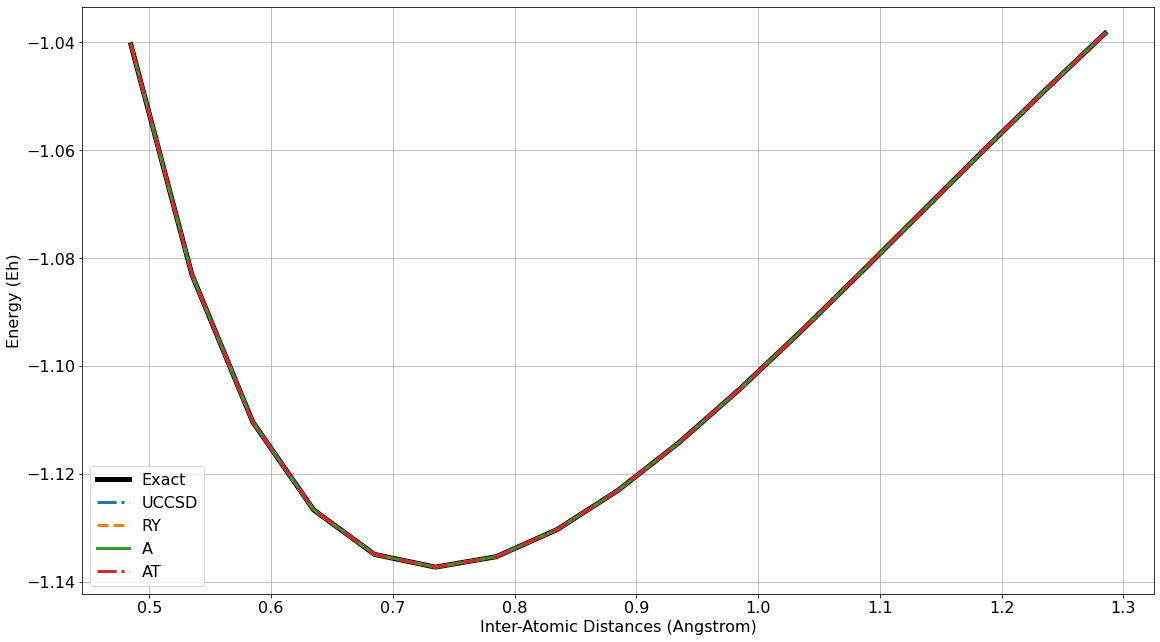

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.title("$H_2$ Molecule Energy vs Inter-atomic distances\t-\tParity Mapper")

# fig.text(0.75, 0.65, f'Exact Energy: {numpy_exact_energy:.3f} Eh')

plt.rc('font', size=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)

# plt.xlim([-1, 51])

# ax.set_facecolor("#293952")
ax.set_xlabel('Inter-Atomic Distances (Angstrom)')
ax.set_ylabel('Energy (Eh)')
ax.grid()

# plt.plot(inter_atomic_dists, numpy_eigensolver_electronic_ground_energies, label="Exact", color="#000000", linewidth=5, linestyle=None)
# plt.plot(inter_atomic_dists, uccsd_total_ground_state_energies, label="UCCSD", linewidth=3, linestyle="-.")
# plt.plot(inter_atomic_dists, ryrz_electronic_ground_energies, label="RYRZ", linewidth=3, linestyle="--")


plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies, label="Exact", color="#000000", linewidth=5, linestyle=None)
plt.plot(inter_atomic_dists, uccsd_total_ground_state_energies, label="UCCSD", linewidth=3, linestyle="-.")
plt.plot(inter_atomic_dists, ry_total_ground_state_energies, label="RY", linewidth=3, linestyle="--")
# plt.plot(inter_atomic_dists, ryrz_total_ground_state_energies, label="RYRZ", linewidth=3, linestyle=":")
plt.plot(inter_atomic_dists, a_total_ground_state_energies, label="A", linewidth=3, linestyle=None)
plt.plot(inter_atomic_dists, at_total_ground_state_energies, label="AT", linewidth=3, linestyle="-.")


plt.legend()

fig.savefig("vqe_h2_pa_id_all.png", dpi=200)